# Beyond Churn Prediction and Churn Uplift

Why predicting churn is not enough. And not even estimating churn uplift!

You need to estimate the impact on profits in order to get the best result

In [118]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [119]:
from src.utils import *
from src.dgp import DGP

Suppose we 

In [211]:
class dgp_subscription_program(DGP):
    """DGP: promotional email"""
    X: list[str] = ['age', 'rev_old', 'rev_change']
    D: str = 'gift'
    Y: list[str] = ['churn', 'revenue']

    def generate_baseline(self, seed:int = 0):
        np.random.seed(seed)
        months = np.random.exponential(5, self.n)
        rev_old = np.maximum(0, np.random.exponential(7, self.n) - 2)
        rev_change = np.random.normal(0, 2, self.n)
        churn_c = np.random.beta(1 - rev_change*(rev_change<0), 2 + rev_old) > 0.4
        rev_c = 0.8*rev_old + 0.2*np.maximum(0, np.random.exponential(7, self.n) - 2)
        df = pd.DataFrame({'months': months, 'rev_old': rev_old, 'rev_change': rev_change,
                           'churn_c': churn_c, 'revenue_c': rev_c})
        return df

    def add_treatment_effect(self, df, seed:int = 1):
        np.random.seed(seed)
        effect_c = - np.random.binomial(1, 0.3, self.n) * (df.months<7)
        df['effect_on_churn'] = effect_c * (df.churn_c==1)
        effect_r = np.random.normal(0.9, 0.5, self.n)* (df.months>3)
        df['effect_on_revenue'] = np.maximum(-df.revenue_c, effect_r)
        return df

    def add_assignment(self, df: pd.DataFrame, seed: int = 2) -> pd.DataFrame:
        np.random.seed(seed)
        df[self.D] = np.random.binomial(1, 0.5, self.n)
        return df

    def add_post_treatment_variables(self, df : pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        df.revenue *= (1-df.churn)
        return df

In [212]:
dgp = dgp_subscription_program(n=100_000)
df = dgp.generate_data()
df.head()

,months,rev_old,rev_change,gift,churn,revenue
0,3.98,3.36,0.86,0,0,7.28
1,6.28,14.41,-2.77,1,0,11.60
2,4.62,2.89,-2.21,0,0,3.59
3,3.94,0.00,-3.26,0,1,0.00
4,2.76,3.25,-3.43,0,0,5.33


We have information on `100_000` customers for which we observe the number of `months` they have subscribed to the premium tier, the revenues in the last month (`rev_old`), the change of revenue between last month and the previous one (`rev_change`), the

```mermaid
flowchart TD
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:3px;
classDef empty width:-10px,height:-10px,fill:#000000,stroke-width:0px;

W((1$ gift))
D1(( ))
D2(( ))
Y1((churn))
Y2((revenue))
X1((months))
X2((revenue change))
X3((revenue old))

W --- D1
X1 --- D1
D1 --> Y1
W --- D2
X1 --- D2
D2 --> Y2
Y1 --> Y2
X2 --> Y1
X3 --> Y1
X3 --> Y2

class W,Y1,Y2,X1,X2,X3 included;
class D1,D2 empty;

linkStyle 0,2,3,5 stroke:#2db88b,stroke-width:6px;
linkStyle 1,4,6,7,8,9 stroke:#003f5c,stroke-width:6px;
```

In [213]:
df.churn.mean()

0.19767

In [215]:
Y = ['churn', 'revenue']
W = 'gift'
X = ['months', 'rev_old', 'rev_change']

In [220]:
smf.ols("churn ~ " + W + " + " + " + ".join(X), data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3271,0.002,151.440,0.000,0.323,0.331
gift,-0.1173,0.002,-51.521,0.000,-0.122,-0.113
months,0.0050,0.000,21.832,0.000,0.005,0.005
rev_old,-0.0181,0.000,-108.061,0.000,-0.018,-0.018
rev_change,-0.0497,0.001,-87.412,0.000,-0.051,-0.049


<Axes: xlabel='revenue', ylabel='Count'>

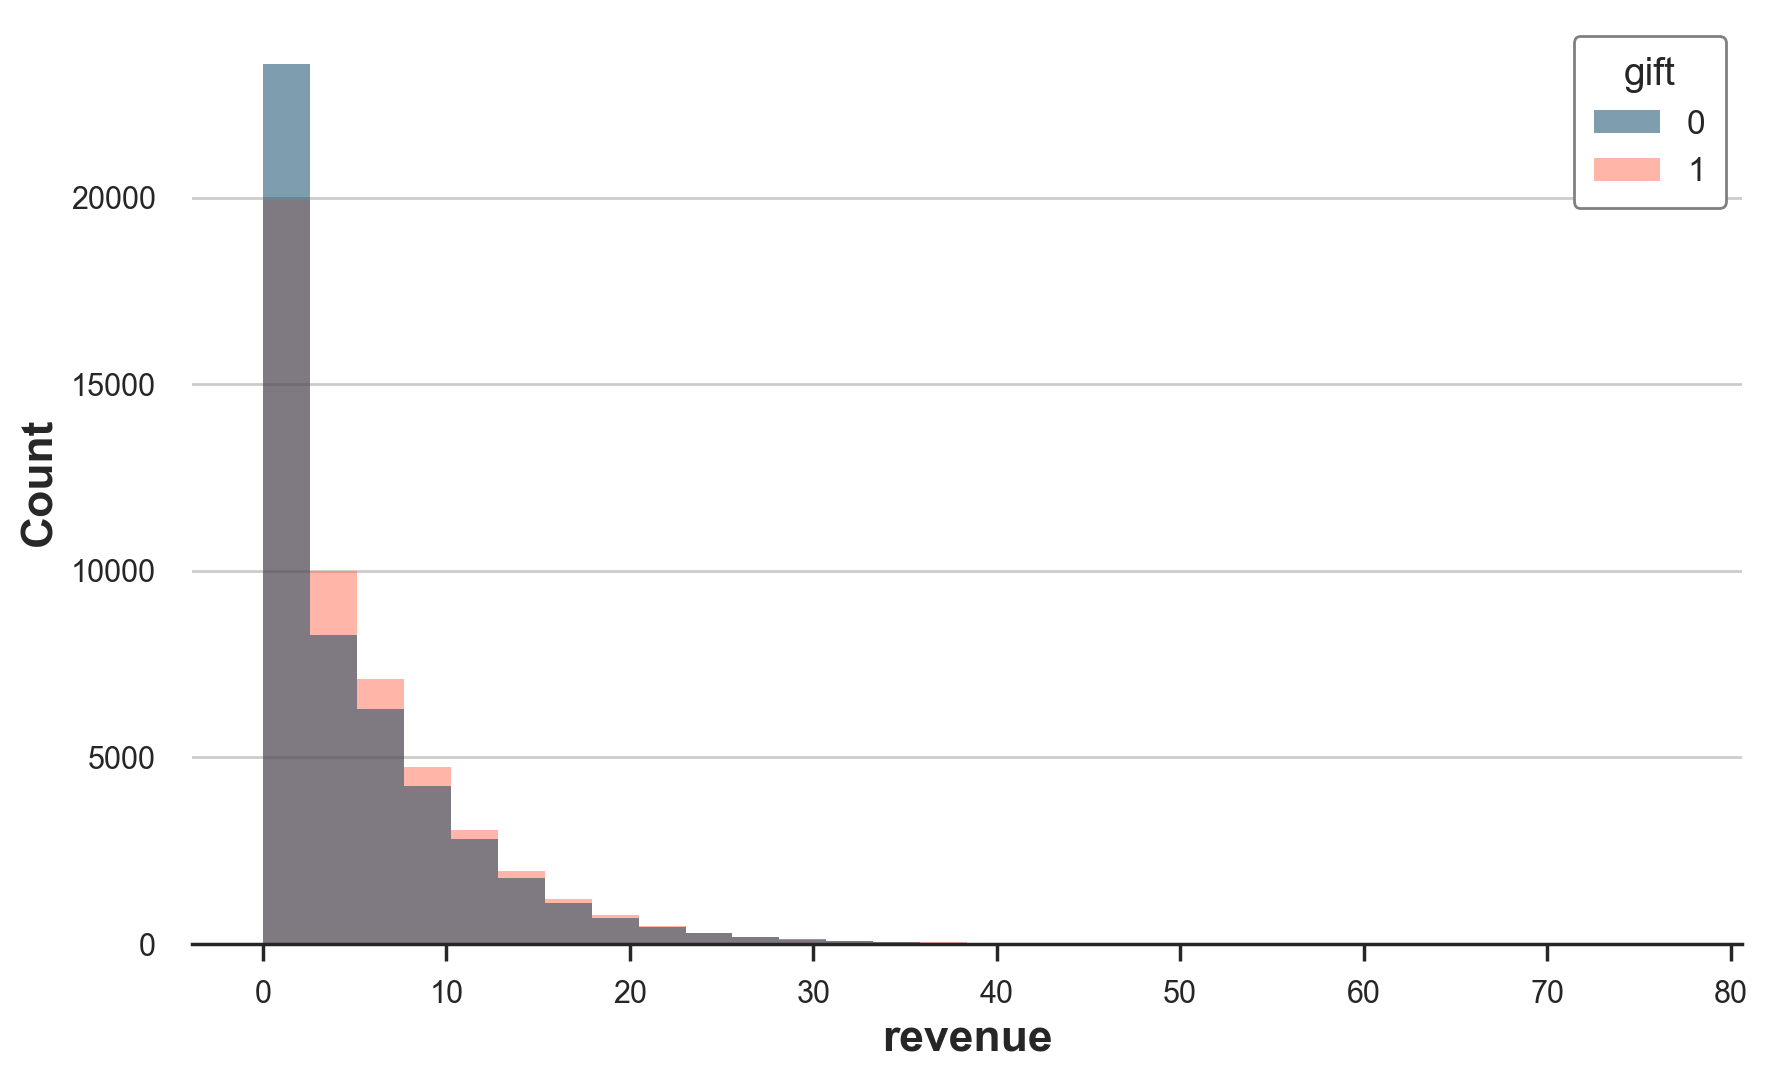

In [222]:
sns.histplot(data=df, x='revenue', hue=W, bins=30)

In [223]:
smf.ols("revenue ~ " + W + " + " + " + ".join(X), data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3691,0.010,37.910,0.000,0.350,0.388
gift,0.6317,0.010,61.560,0.000,0.612,0.652
months,0.0120,0.001,11.768,0.000,0.010,0.014
rev_old,0.8251,0.001,1092.846,0.000,0.824,0.827
rev_change,0.1457,0.003,56.777,0.000,0.141,0.151


In [224]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from flaml.default import LGBMClassifier, LGBMRegressor, RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

model_y = LGBMRegressor()
model_w = LGBMClassifier()

In [225]:
from econml.dr import DRLearner

In [226]:
cost = 1

In [227]:
def evaluate_policy(policy):
    data = dgp.generate_data(seed_data=11, seed_assignment=12, keep_po=True)
    data['profits'] = (1 - data.churn) * data.revenue
    ad = policy(data)
    baseline = (1-data.churn_c) * data.revenue_c
    effect = (ad) * (1-data.churn_t) * (data.revenue_t-cost) + (1-ad) * (1-data.churn_c) * data.revenue_c
    return np.sum(effect - baseline)

In [228]:
optimal_policy_churn = lambda df : - df['effect_on_churn'] * df['revenue_c'] > cost
evaluate_policy(optimal_policy_churn)

8048.5

In [229]:
optimal_policy_revenue = lambda df : df['effect_on_revenue'] * (1 - df['churn_c']) > cost
evaluate_policy(optimal_policy_revenue)

6301.899999999999

In [230]:
optimal_policy_interaction = lambda df : - df['effect_on_churn'] * df['effect_on_revenue'] > cost
evaluate_policy(optimal_policy_interaction)

2216.19

In [231]:
def optimal_policy(df):
    pi = - df['effect_on_churn'] * (df['revenue_c'] + df['effect_on_revenue'])  
    pi += df['effect_on_revenue'] * (1 - df['churn_c'])
    return pi > cost
evaluate_policy(optimal_policy)

14695.079999999998

Target churning customers

In [232]:
model_churn = clone(model_w).fit(X=df[X], y=df['churn'])

policy_churn = lambda df : (model_churn.predict_proba(df[X])[:,1] > 0.2)
evaluate_policy(policy_churn)

-5453.03

Target revenue customers

In [233]:
model_revenue = clone(model_y).fit(X=df[X], y=df['revenue'])

policy_revenue = lambda df : (model_revenue.predict(df[X]) > 10*cost)
evaluate_policy(policy_revenue)

-7337.449999999999

Target churn uplift customers

In [234]:
DR_learner_churn = DRLearner(model_regression=model_y, model_propensity=model_w, model_final=model_y)
DR_learner_churn.fit(df['churn'], df[W], X=df[X]);

policy_churn_lift = lambda df : DR_learner_churn.effect(df[X]) < 0
evaluate_policy(policy_churn_lift)

-28354.979999999996

In [240]:
DR_learner_churn = DRLearner(model_regression=model_y, model_propensity=model_w, model_final=model_y)
DR_learner_churn.fit(df['churn'], df[W], X=df[X]);
model_revenue_1 = clone(model_y).fit(X=df.loc[df[W] == 1, X], y=df.loc[df[W] == 1, 'revenue'])

policy_churn_lift = lambda df : - DR_learner_churn.effect(df[X]) * model_revenue_1.predict(df[X]) > cost
evaluate_policy(policy_churn_lift)

384.78

Combine 

$$
\tau_{\pi} = \hat{r}_1 * (1 - \hat{c}_1) - \hat{r}_0 * (1 - \hat{c}_0)
$$

which we can rewrite as 

$$
\begin{aligned}
\tau_{\pi} &= \hat{r}_1 * (1 - \hat{c}_1) - \hat{r}_0 * (1 - \hat{c}_0) = \newline
&= \hat{r}_1 * (1 - \hat{c}_1) - \underbrace{\hat{r}_1 * (1 - \hat{c}_0) + \hat{r}_1 * (1 - \hat{c}_0)}_{\text{add and subtract}} - \hat{r}_0 * (1 - \hat{c}_0) = \newline
&= - \hat{r}_1 * \tau_c + \hat{r}_1 * (1 - \hat{c}_0) - \hat{r}_0 * (1 - \hat{c}_0) = \newline
&= - \hat{r}_1 * \tau_c + \tau_r * (1 - \hat{c}_0)
\end{aligned}
$$

In [243]:
model_churn_0 = clone(model_w).fit(X=df.loc[df[W] == 0, X], y=df.loc[df[W] == 0, 'churn'])

df_surv = df[df.churn == 0]
DR_learner_survrev = DRLearner(model_regression=model_y, model_propensity=model_w, model_final=model_y)
DR_learner_survrev.fit(df_surv['revenue'], df_surv[W], X=df_surv[X]);

def policy_comb_lift(df): 
    pi = - DR_learner_churn.effect(df[X]) * model_revenue_1.predict(df[X])
    pi += DR_learner_survrev.effect(df[X]) * (1 - model_churn_0.predict(df[X]))
    return pi > cost
evaluate_policy(policy_comb_lift)

772.8700000000001

Target revenue uplift customers

In [244]:
DR_learner_revenue = DRLearner(model_regression=model_y, model_propensity=model_w, model_final=model_y)
DR_learner_revenue.fit(df['revenue'], df[W], X=df[X]);

policy_revenue_lift = lambda df : (DR_learner_revenue.effect(df[X]) > cost)
evaluate_policy(policy_revenue_lift)

2018.8600000000001

Plot

In [245]:
def plot_avg_by_age(df, var, ax, **kwargs):
    temp = df.copy()
    temp['months'] = temp['months'].round(0)
    temp = temp.groupby('months', as_index=False)[[var]].mean()
    sns.lineplot(data=temp, x='months', y=var, ax=ax).set(ylabel='', ylim=(-0.1, 1.1), xlim=(0, 13), **kwargs)

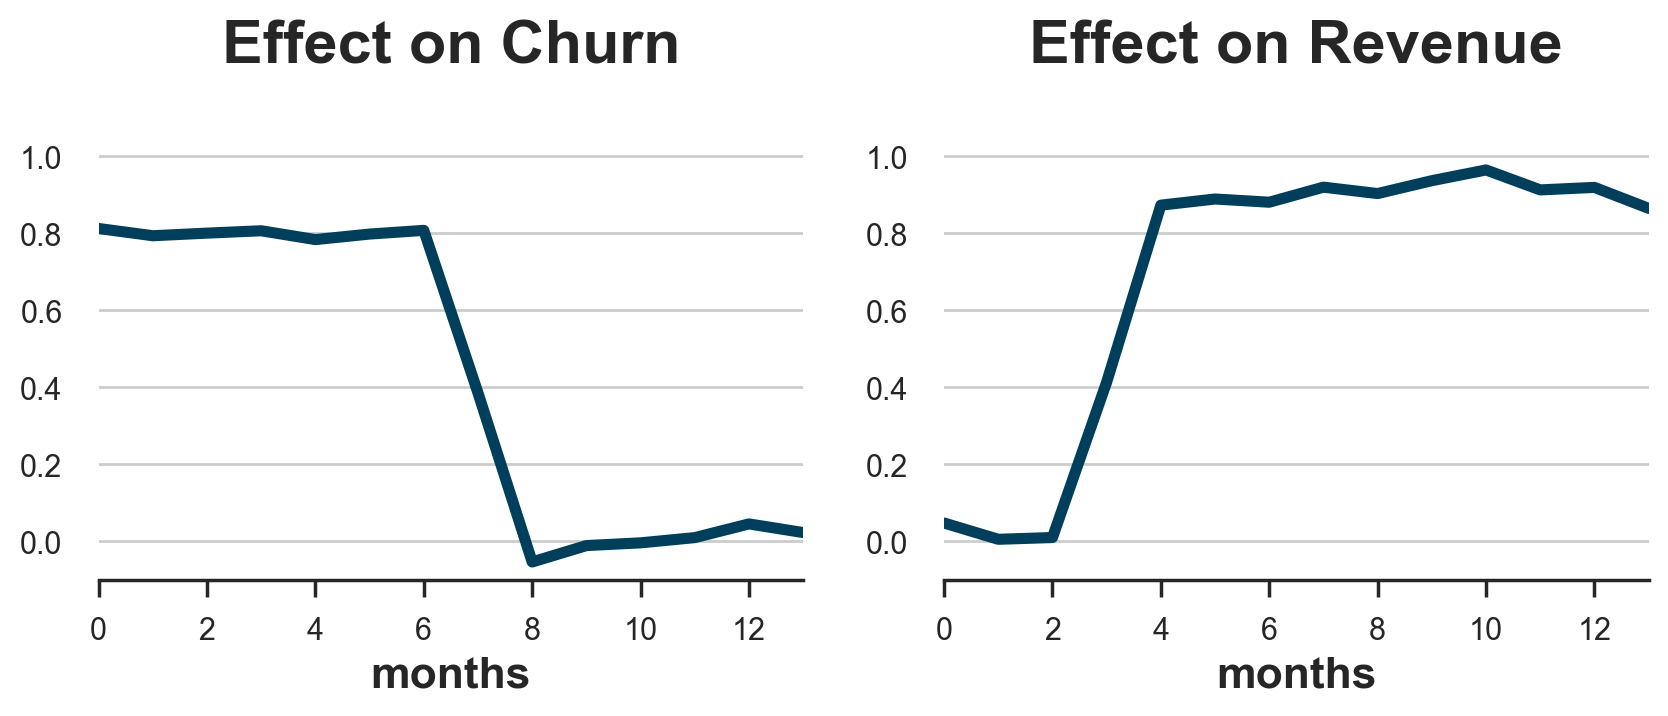

In [246]:
df['effect_churn_hat'] = np.mean(model_revenue.predict(df[X])) * -DR_learner_churn.effect(df[X])
df['effect_revenue_hat'] = DR_learner_survrev.effect(df[X])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
plot_avg_by_age(df, 'effect_churn_hat', ax1, title="Effect on Churn")
plot_avg_by_age(df, 'effect_revenue_hat', ax2, title="Effect on Revenue")

In [247]:
policies = [policy_churn, policy_revenue, policy_churn_lift, policy_comb_lift, policy_revenue_lift] 
df_results = pd.DataFrame()
df_results['policy'] = ['churn', 'revenue', 'churn_L', 'comb_L', 'revenue_L']
df_results['value'] = [evaluate_policy(policy) for policy in policies]

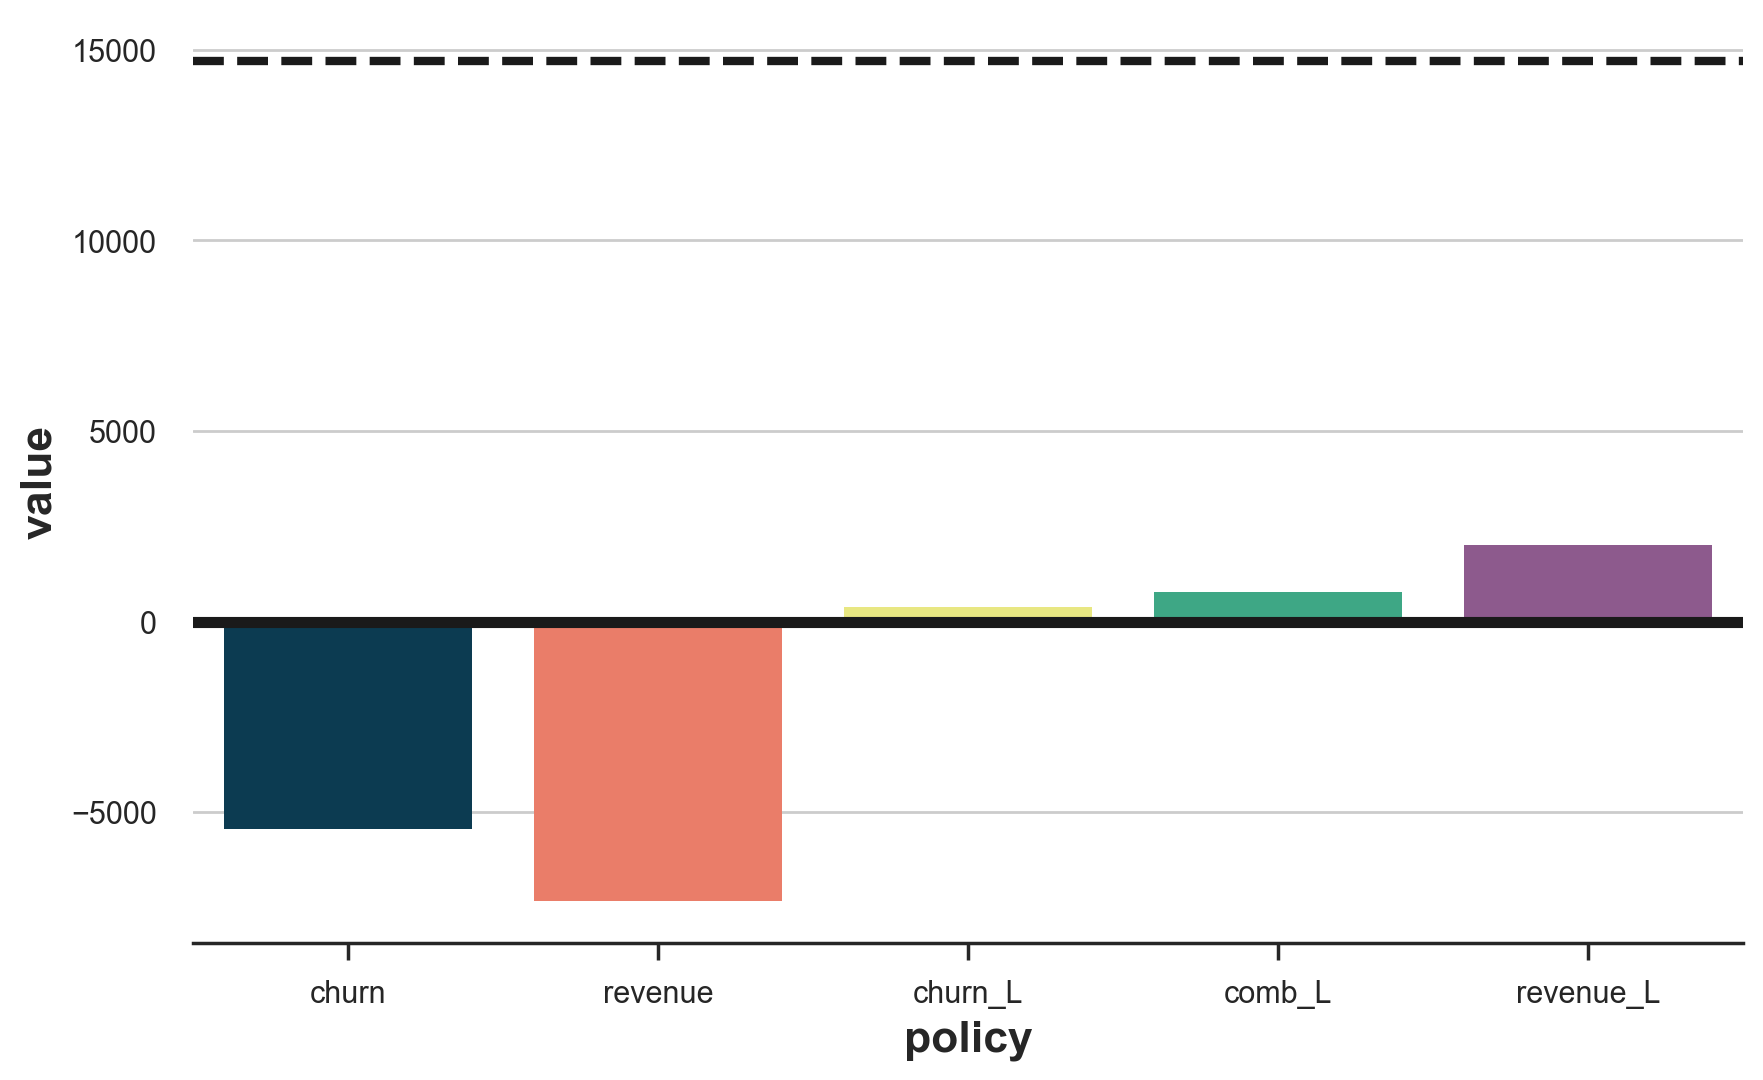

In [248]:
fig, ax = plt.subplots()
sns.barplot(df_results, x='policy', y='value')
plt.axhline(0, c='k')
plt.axhline(evaluate_policy(optimal_policy), c='k', ls='--', lw=3)

### Bonus: weighting

In [249]:
DR_learner_revenue_w = DRLearner(model_regression=model_y, model_propensity=model_w, model_final=model_y)
w = np.exp(1 - np.abs(DR_learner_revenue.effect(df[X]) - cost))
DR_learner_revenue_w.fit(df['revenue'], df[W], X=df[X], sample_weight=w);

policy_revenue_lift_w = lambda df : (DR_learner_revenue_w.effect(df[X]) > cost)
evaluate_policy(policy_revenue_lift_w)

1429.86

## Conclusion

### References

- Lemmens, Gupta (2020), ["Managing Churn to Maximize Profits"](https://www.hbs.edu/ris/Publication%20Files/14-020_2d6c9da0-94d3-4dd5-9952-d81feb432f61.pdf)

- Bonvini, Kennedy, Keele (2021), ["Minimax optimal subgroup identification"](https://arxiv.org/abs/2306.17464)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/beyond_churn.ipynb